In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

In [2]:
import pdb
import math
from scipy import integrate
from scipy import special
import numpy as np
from cmath import *
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
np.seterr(all='raise')
special.seterr(all='raise')
warpSize = 32
blockSize = 1024
from patch_geo_func import *

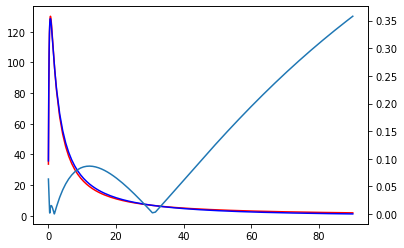

In [3]:
den_area = 850 # mm^2 O'Kusky 1982 for the neuronal density we use later
# exp. measurement
darea = lambda E: 140*(0.78+E)**(-2.2) # Van Essen 1984 Vision Research "standard" map, 5232x1024
area_slice = lambda E: np.pi*E*darea(E)
# model fit
a = 0.635
b = 96.7
k = np.sqrt(140)*0.873145
s1 = 0.76
s2 = 0.1821
model_block = lambda p, e: model_block_ep(e,p,k,a,b,s1,s2)
half_stripe_width = 0 # to be read from elastic net simulation result

def model_slice(e):
    dslice = lambda p: model_block(p, e)
    r = integrate.quad(dslice, -np.pi/2, np.pi/2)
    return r[0]

ecc = np.hstack((np.linspace(0,2.5,50), np.linspace(2.5,90,100)))
ecc = ecc[1:]
fig = plt.figure('model_compare')
ax = fig.add_subplot(111)
model_s = np.array([model_slice(e) for e in ecc])
exp_s = np.array([area_slice(e) for e in ecc])
ax.plot(ecc, exp_s,'r')
ax.plot(ecc, model_s,'b')
ax2 = ax.twinx()
ax2.plot(ecc, np.abs(exp_s - model_s)/exp_s)

In [4]:
# total v1 size
r = integrate.quad(area_slice,0,90)
v1_size_exp = r[0]
r = integrate.dblquad(model_block,0,90,-pi/2,pi/2)
v1_size_model = r[0]
display(Latex(rf'Size of V1 = {v1_size_exp:.3f} $mm^2$ (exp.) ~ {v1_size_model:.3f} $mm^2$ (model) ({v1_size_model*100/v1_size_exp:.3f}%)'))
ecc = 2.0
r = integrate.quad(area_slice,0,ecc)
area_exp = r[0]
r = integrate.dblquad(model_block,0,ecc,-np.pi/2,np.pi/2)
area_model = r[0]
display(Latex(rf'A patch of v1 from eccentricity {0} to {ecc} degree yields {area_exp:.3f}  $mm^2$ (exp.) ~ {area_model:.3f}  $mm^2$ (model) ({area_model*100/area_exp:.3f}%)'))
model_ratio = den_area/v1_size_model
print(f'ratio: {model_ratio:.3f}')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

ratio: 0.820


In [5]:
print('O''Kusky 1982; Kelly & Hawken 2017; M.Schmidt 2018, assuming constant density near the fovea')
print('##### L4 #####')
surface_den_L4Cbeta = 30000*model_ratio # per mm^2
display(Latex(rf'Rescale density 30000 per $mm^2$ in O\'Kusky 1982 to {surface_den_L4Cbeta:.3f} per $mm^2$ to keep constant number of neurons'))
assert(30000*den_area == surface_den_L4Cbeta*v1_size_model)
_n_L4Cbeta = area_model*surface_den_L4Cbeta # 32^4 * 10 ~ 10.4 million
n_L4Cbeta = int((_n_L4Cbeta+blockSize-1)//blockSize*blockSize)
nblock_L4Cbeta = n_L4Cbeta//blockSize
block_area_L4Cbeta = area_model/nblock_L4Cbeta
L4_area = area_model
print(f'Rounding number of neurons in L4Cbeta from {_n_L4Cbeta:.3f} to {n_L4Cbeta} = {nblock_L4Cbeta} x {blockSize}')
display(Latex(rf'area per block = {block_area_L4Cbeta:.3f} $mm^2$'))
display(Latex(rf'model density = {n_L4Cbeta/L4_area:.3f} per $mm^2$\n'))
print('##### L2/3 #####')
surface_den_L23 = 18000*model_ratio # per mm^2
display(Latex(rf'Rescale density 18000 per $mm^2$ in O\'Kusky 1982 to {surface_den_L23:.3f} per $mm^2$ to keep constant number of neurons'))
_n_L23 = area_model*surface_den_L23
n_L23 = int((_n_L23+blockSize-1)//blockSize*blockSize)
nblock_L23 = n_L23//blockSize
block_area_L23 = area_model/nblock_L23
L23_area = area_model
print(f'Rounding number of neurons in L4Cbeta from {_n_L23:.3f} to {n_L23} = {nblock_L23} x {blockSize}')
display(Latex(f'area per block = {block_area_L23:.3f} $mm^2$'))
display(Latex(f'model density = {n_L23/L23_area:.3f} per $mm^2$'))

OKusky 1982; Kelly & Hawken 2017; M.Schmidt 2018, assuming constant density near the fovea
##### L4 #####


<IPython.core.display.Latex object>

Rounding number of neurons in L4Cbeta from 5333310.041 to 5334016 = 5209 x 1024


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

##### L2/3 #####


<IPython.core.display.Latex object>

Rounding number of neurons in L4Cbeta from 3199986.024 to 3200000 = 3125 x 1024


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [ ]:
blockSize = 1024
fig, pos, xlim, ylim = plot_patch(a,b,k,ecc,half_stripe_width,nblock_L4Cbeta,ax=None,skip=602,s1=0.76,s2=0.1821,ret_fig=True,blockSize=blockSize)
#fig, pos = plot_patch(a,b,k,ecc,L4_area/32,32,ax=None,skip=602,s1=0.76,s2=0.1821,ret_fig=True,blockSize=1024)

In [8]:
fig.savefig('sobol_test_full_density.png', dpi = 600)

dim = 2
pos_filename = 'V1_pos_2D.bin'
position_discrimination_digits = 1
with open(pos_filename, 'wb') as f:
    np.array([nblock_L4Cbeta, blockSize, dim]).astype('u4').tofile(f)        
    pos[:,:2,:].tofile(f) #f8
    
dim = 3
pos_filename = 'V1_pos_3D.bin'
position_discrimination_digits = 1
with open(pos_filename, 'wb') as f:
    np.array([nblock_L4Cbeta, blockSize, dim]).astype('u4').tofile(f)        
    pos.tofile(f) #f8

characteristic block width = 2.602353439256627
100.000% slice #5 , 6/6

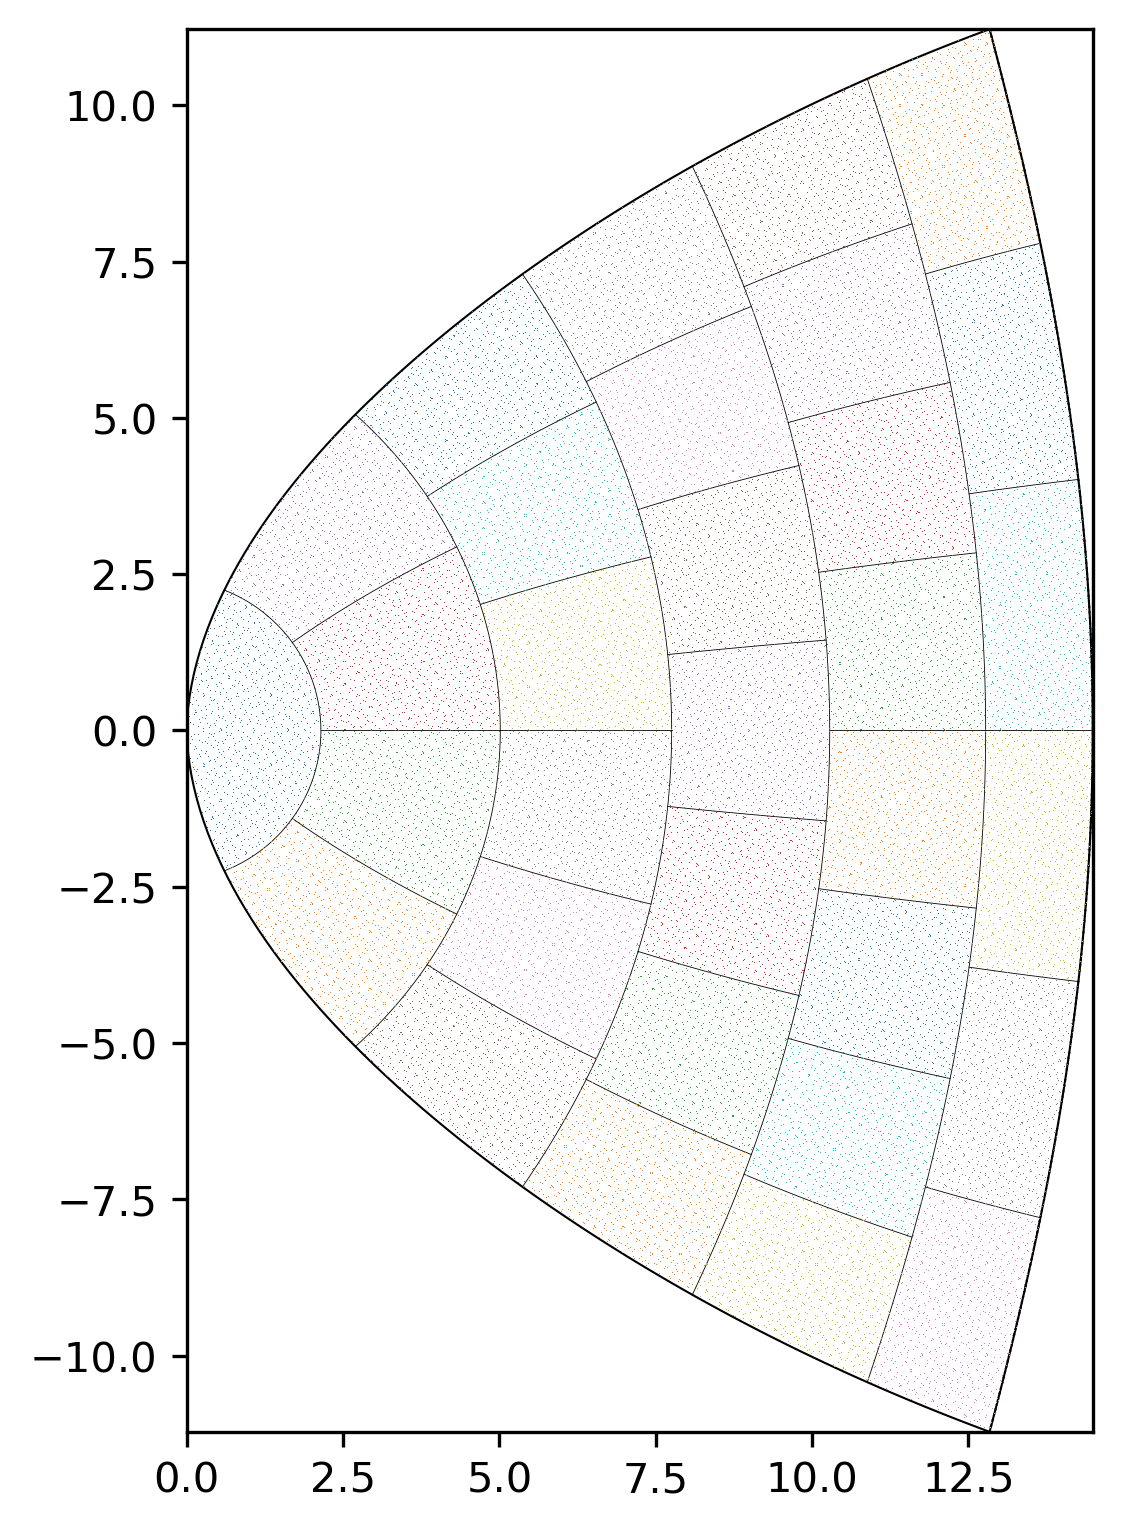

In [10]:
nblock = 32
blockSize = 1024
fig, pos, xlim, ylim = plot_patch(a,b,k,ecc,half_stripe_width,nblock,ax=None,skip=32,s1=0.76,s2=0.1821,ret_fig=True,blockSize=blockSize)

In [12]:
fig.savefig('sobol_test_low_density.png', dpi = 600)
dim = 2
pos_filename = 'V1_pos_2D_lowDensity.bin'
with open(pos_filename, 'wb') as f:
    np.array([nblock, blockSize, dim]).astype('u4').tofile(f)        
    pos[:,:2,:].tofile(f) #f8
    
dim = 3
pos_filename = 'V1_pos_3D_lowDensity.bin'
with open(pos_filename, 'wb') as f:
    np.array([nblock, blockSize, dim]).astype('u4').tofile(f)
    pos.tofile(f)

In [19]:
for i in range(pos.shape[0]):
    for j in range(pos.shape[2]):
        assert(np.sum((pos[i,:3,j].reshape(3,1) - pos[i,:3,:]==0).all(0)) == 1)

In [25]:
%debug

> c:\users\gueux\patchv1\patch_geo_func.py(215)get_pos_3d()
    213             if ((ptmp - ptmp[:,j].reshape((2,1)) == 0).all(0)).any():
    214                 select[j] = False
--> 215                 assert(not((ptmp - ptmp[:,j].reshape((2,1)) == 0).all(0)).any())
    216             if i > 0:
    217                 if ((pos[:2,:i] - ptmp[:,j].reshape((2,1)) == 0).all(0)).any():



ipdb>  ptmp - ptmp[:,j].reshape((2,1))


array([[ 0.        , -1.0381014 , -1.25461042, ..., -0.55908328,
        -1.6433558 , -1.47841791],
       [ 0.        ,  2.51721547,  0.5801559 , ...,  0.62456175,
         3.22708226, -1.36146533]])


ipdb>  q


characteristic length =

In [33]:
cl = np.sqrt(block_area_L4Cbeta) * 1000
display(Latex(f'{cl:.3f} $\mu m$'))

<IPython.core.display.Latex object>

In [35]:
md = np.power(cl*cl*100/1024,1/3)
display(Latex(f'~204x204x100 $\mu m^3$ (1024 neurons) per block, average inter-neuron(soma)-distance = {md:.3f} $\mu m$'))

<IPython.core.display.Latex object>

conduction velocity ~ 1m/s, being unmylineated horizontal connections  
(0.3m/s for L2/3 and upper L4) <i>Girard et al J Neurophysiol 2001</i>  
minmum delay = 0.016 ms, no spike-correction is needed for time step (dt) < minimum delay
100Hz instantaneous firing rate, 1000 connections leads to ~ 1 spike every 0.01ms. 

In [36]:
dt = 1 #ms
nob = 1000/cl
print(nob)

4.902706663509537


dt = 1ms means neurons in the nearest 5~6 blocks needs to be considered for spike correction  
dt = 0.125ms (1/8) suffice for spike correction within block, #ASSUMPTION# nearfield spike correction only (neurons at block boundarys are neglected) spikes send to the other blocks are resolved after the current step.

#dt = 0.125ms is thus limited by the number of threads per block in NVIDIA GPU  
To further increase dt, will need a cross block spike-correction with CPU, or wait for an update from NVIDIA, otherwise results in an extra increase in spike-correction error, maybe tolerable.

In [37]:
time = 500
dt = 0.0625
batch_time_per_dt = 500e-6 #sec
nstep = time//dt
blocks = 10240
resident_blocks = 8
time_cost = np.int(blocks/resident_blocks) * batch_time_per_dt * nstep
print('simulate for', time ,'ms with dt =', dt, 'ms cost', time_cost/3600,'h')

simulate for 500 ms with dt = 0.0625 ms cost 1.4222222222222223 h


In [41]:
pos = np.fromfile('server_data/test_3d_pos.bin')

In [44]:
pos = np.reshape(pos,(3,nblock_L4Cbeta,blockSize))

185136 parvo cells inside 2.5 in total > 110,000 connelly and van essen 1984
reached 2.5197792321467416, 2.5028360561220966 with 185406 > 129595 at 2.5197792321467416


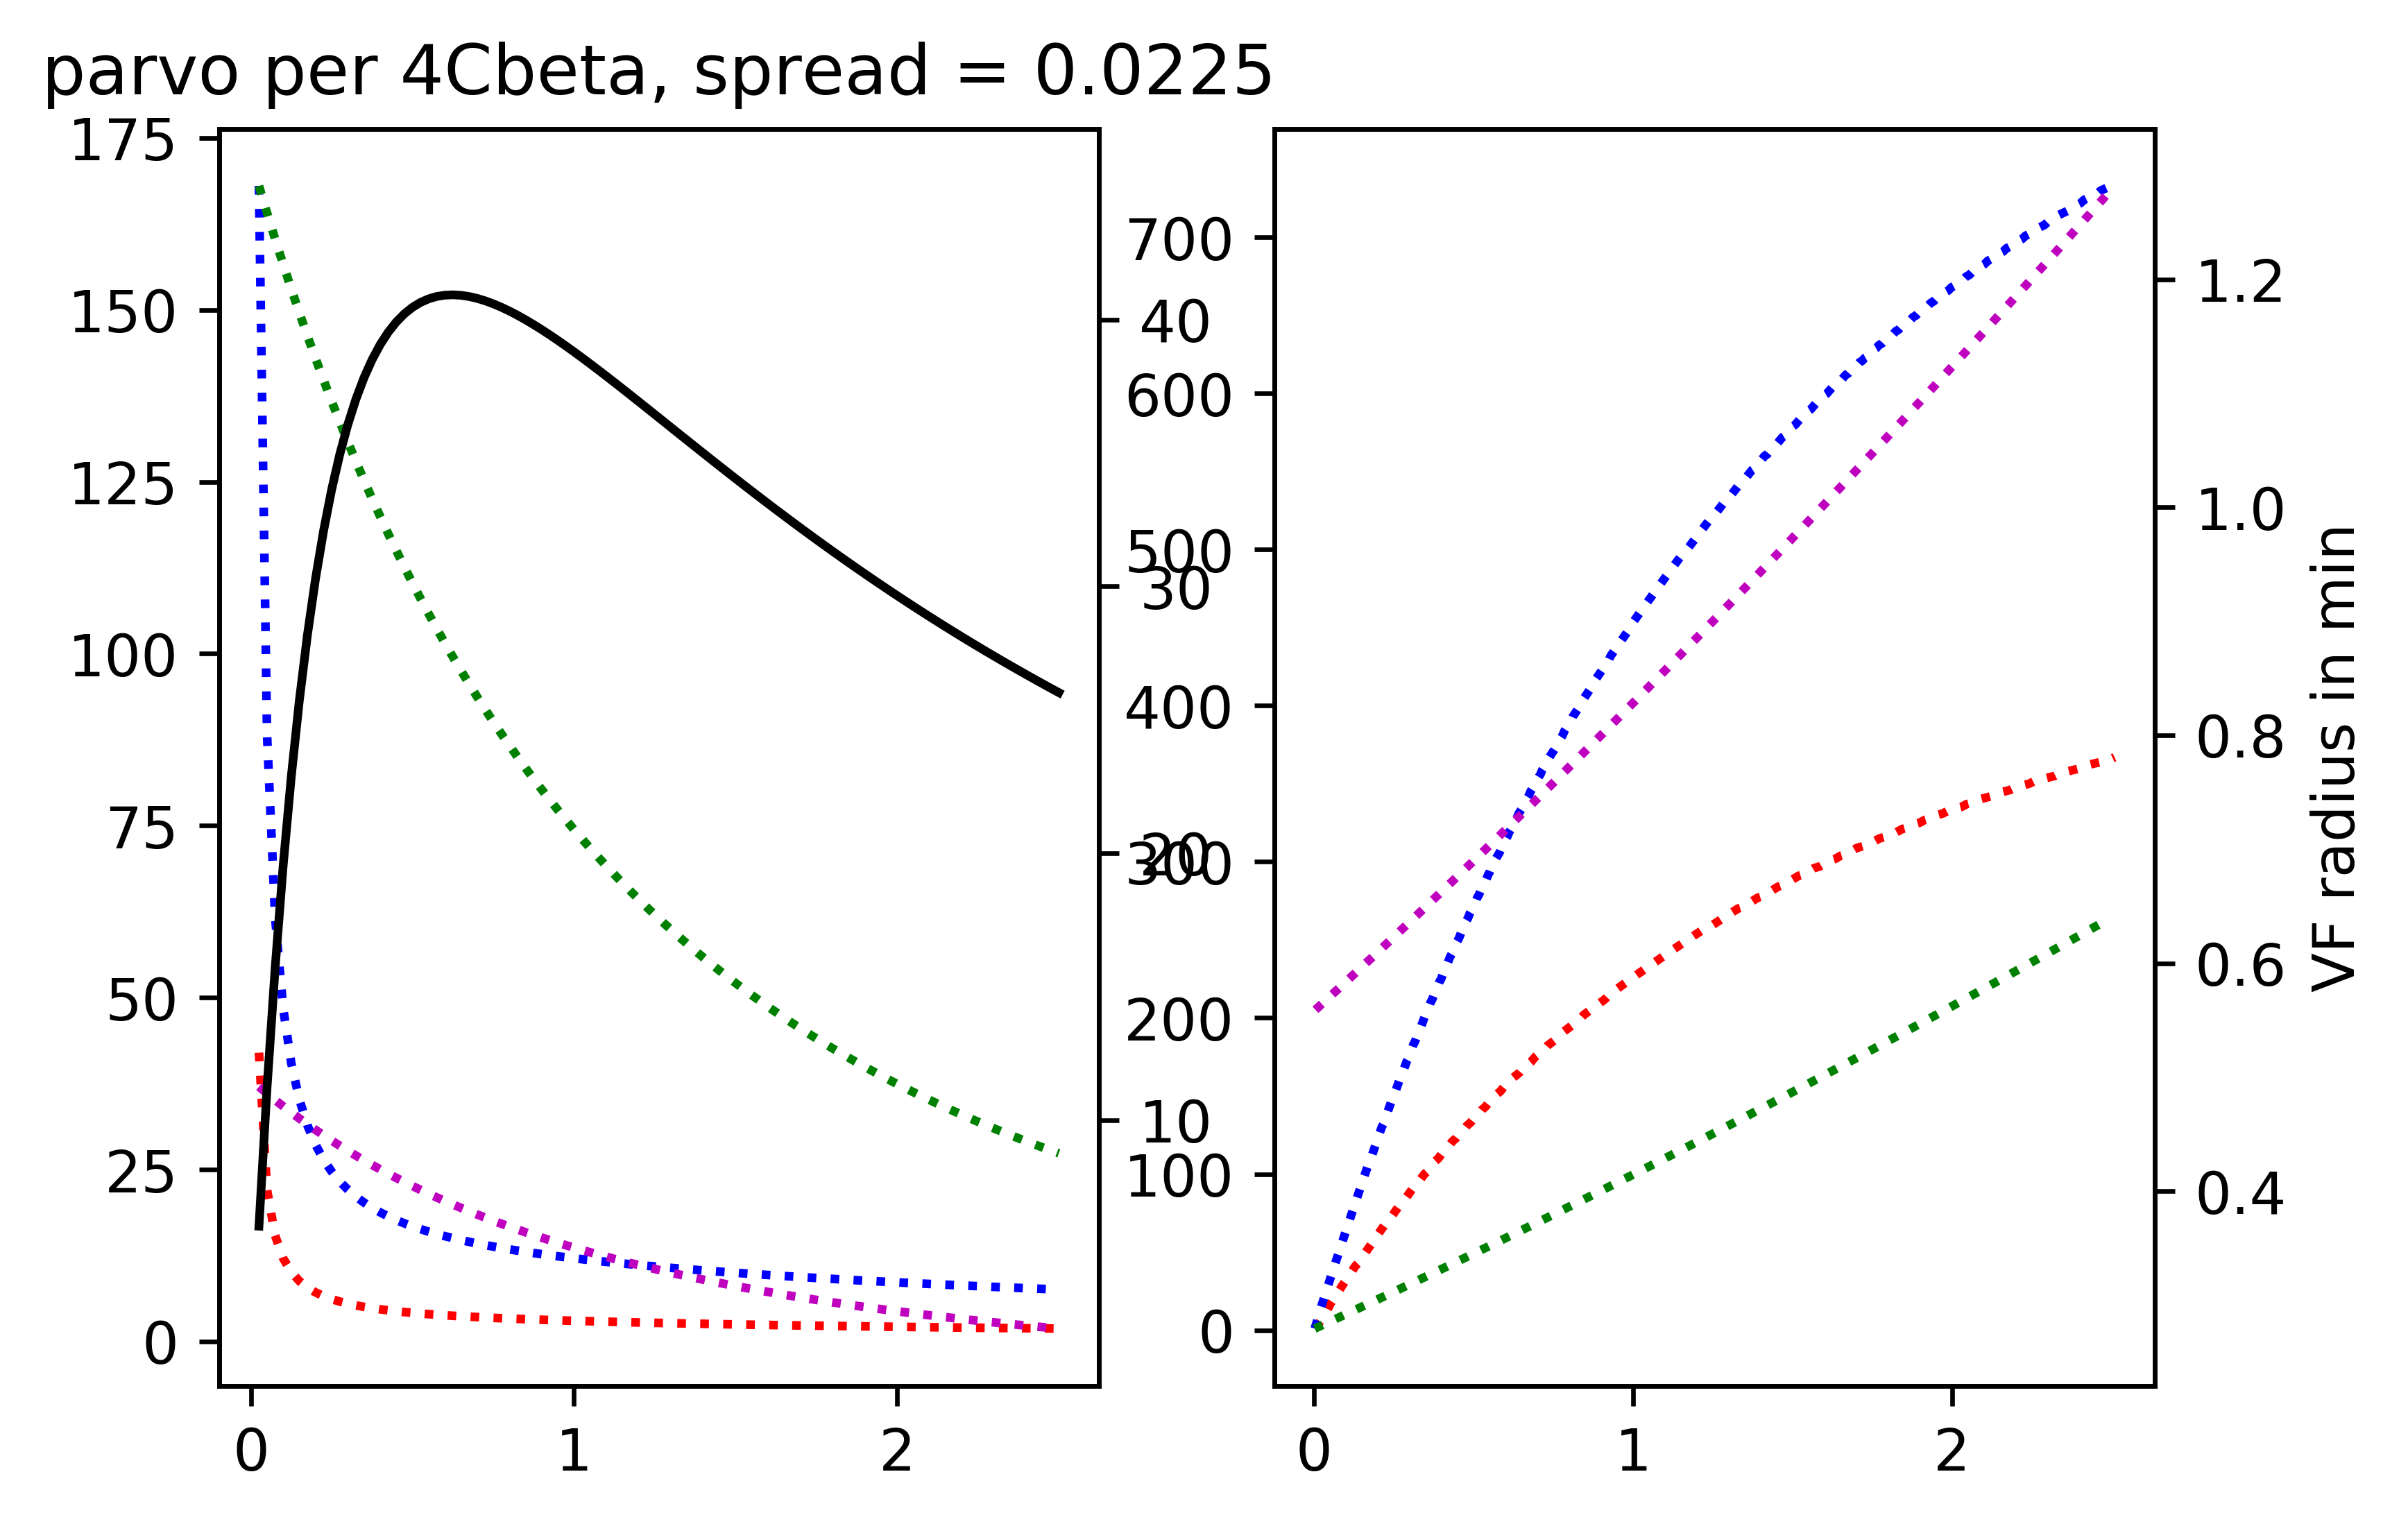

In [6]:
from scipy import integrate
# Maplpeli et al 1996
parvo_den_alt = lambda E: 1011688*(E+2.9144)**(-2.6798) # cells/deg^2
parvo_slice = lambda E: np.pi*E*parvo_den_alt(E)
ecc_Connelly = 2.5
r = integrate.quad(parvo_slice, 0, ecc_Connelly)
nparvo_connelly = round(r[0])
print(f'{nparvo_connelly} parvo cells inside {ecc_Connelly} in total > 110,000 connelly and van essen 1984')
magno_den_alt = lambda E: 2620.2*((E-1.8322)**2+5.5638)**(-0.8012) # cells/deg^2
# in the cortex sheet
# R dendritic spread of L4 neuron
# r dendritic spread of LGN neuron
R_beta = 0.05 # mm Lund 1973
R_alpha = 0.1 # mm
r_parvo = 0.1 # mm Blasdel and lund 1983
r_magno = 0.25 # mm

def M_V1(e):
    dslice = lambda p: model_block(p, e)
    meanM = integrate.quad(dslice, -np.pi/2, np.pi/2)
    return meanM[0]/np.pi

# lgn per cortex cell = den_alt(ecc) * (R+r)^2 * darea(ecc)
#parvo_beta = lambda e: parvo_den_alt(e) * np.power((R_beta + r_parvo),2) * M_V1(e)
spread = np.power((R_beta + r_parvo),2)
parvo_beta = lambda e: parvo_den_alt(e) * spread / M_V1(e)
#parvo_beta = lambda e: 24610 * M_V1(e) / parvo_den_alt(e)

ecc0 = 2.5
ratio_L56 = 1.0 #0.7 5,6 only # within 2.5 degree (Connelly and Van Essen 1984)
ratio_CI = 0.8 # C:I ~ 4:1 (Connelly and Van Essen 1984)
r = integrate.quad(parvo_slice, 0, ecc0)
nparvo0_beta = round(r[0]*0.7)
ecc = np.linspace(0,ecc0,101)
ecc = ecc[1:]
fig = plt.figure('parvo per 4Cbeta',  dpi = 600)
ax = fig.add_subplot(121)
ax.set_title(f'parvo per 4Cbeta, spread = {spread:.4f}')
ax.plot(ecc, [parvo_beta(e)*ratio_L56*ratio_CI for e in ecc], ':b')
ax.plot(ecc, [parvo_beta(e)*ratio_L56*(1-ratio_CI) for e in ecc], ':r')
#ax.set_yscale('log')
ax2 = ax.twinx()
#ax2.plot(ecc, [M_V1(e) for e in ecc], 'r')
ax2.plot(ecc, [parvo_den_alt(e)*ratio_L56*ratio_CI/1000 for e in ecc], ':g')
ax2.plot(ecc, [parvo_den_alt(e)*ratio_L56*(1-ratio_CI)/1000 for e in ecc], ':m')
ax2.plot(ecc, [M_V1(e) for e in ecc], 'k')

def parvo_nLGN_beta(ecc, ratio):
    # dE determined in a iteratively forward way.
    decc = 1/np.sqrt(parvo_den_alt(ecc)* ratio) # 0.7 (from layer 6 and 5 to 4Cbeta guess, Connelly and Van Essen 1984)
    r = integrate.quad(parvo_slice, ecc, ecc+decc)
    return np.int(r[0]*ratio), ecc + decc

def spread_VF(ecc0, ratio):
    current_ecc = 0
    sliced_N = np.array([], dtype = int)
    sliced_ecc = np.array([])
    N = 0
    decc = np.array([])
    while current_ecc < ecc0:
        old_ecc = current_ecc
        sN, current_ecc = parvo_nLGN_beta(current_ecc, ratio)
        sliced_ecc = np.append(sliced_ecc, (old_ecc + current_ecc)/2)
        decc = np.append(decc, current_ecc - old_ecc)
        N = N + sN
        sliced_N = np.append(sliced_N, sN)
    return N, sliced_N, sliced_ecc, decc, current_ecc

nparvo_I5, Isliced_N, Isliced_ecc, Idecc, Icurrent_ecc = spread_VF(ecc0, (1-ratio_CI)*ratio_L56)
nparvo_C6, Csliced_N, Csliced_ecc, Cdecc, Ccurrent_ecc = spread_VF(ecc0, ratio_CI*ratio_L56)
ecc0 = max(Icurrent_ecc, Ccurrent_ecc)

ax = fig.add_subplot(122)
ax2 = ax.twinx()
ax.plot(Isliced_ecc, Isliced_N, ':r')
ax.plot(Csliced_ecc, Csliced_N, ':b')
ax2.plot(Isliced_ecc, Idecc*60, ':m')
ax2.plot(Csliced_ecc, Cdecc*60, ':g')

ax2.set_ylabel('VF radius in min')
nparvo_beta = nparvo_I5 + nparvo_C6
print(f'reached {Icurrent_ecc}, {Ccurrent_ecc} with {nparvo_beta} > {round(nparvo0_beta)} at {ecc0}')

(2, 37278)
#ipsi = 37278, #contra = 148128
0.004659948577413975, 0.0023299742887069874
2.509097406283761, 2.497503397881987


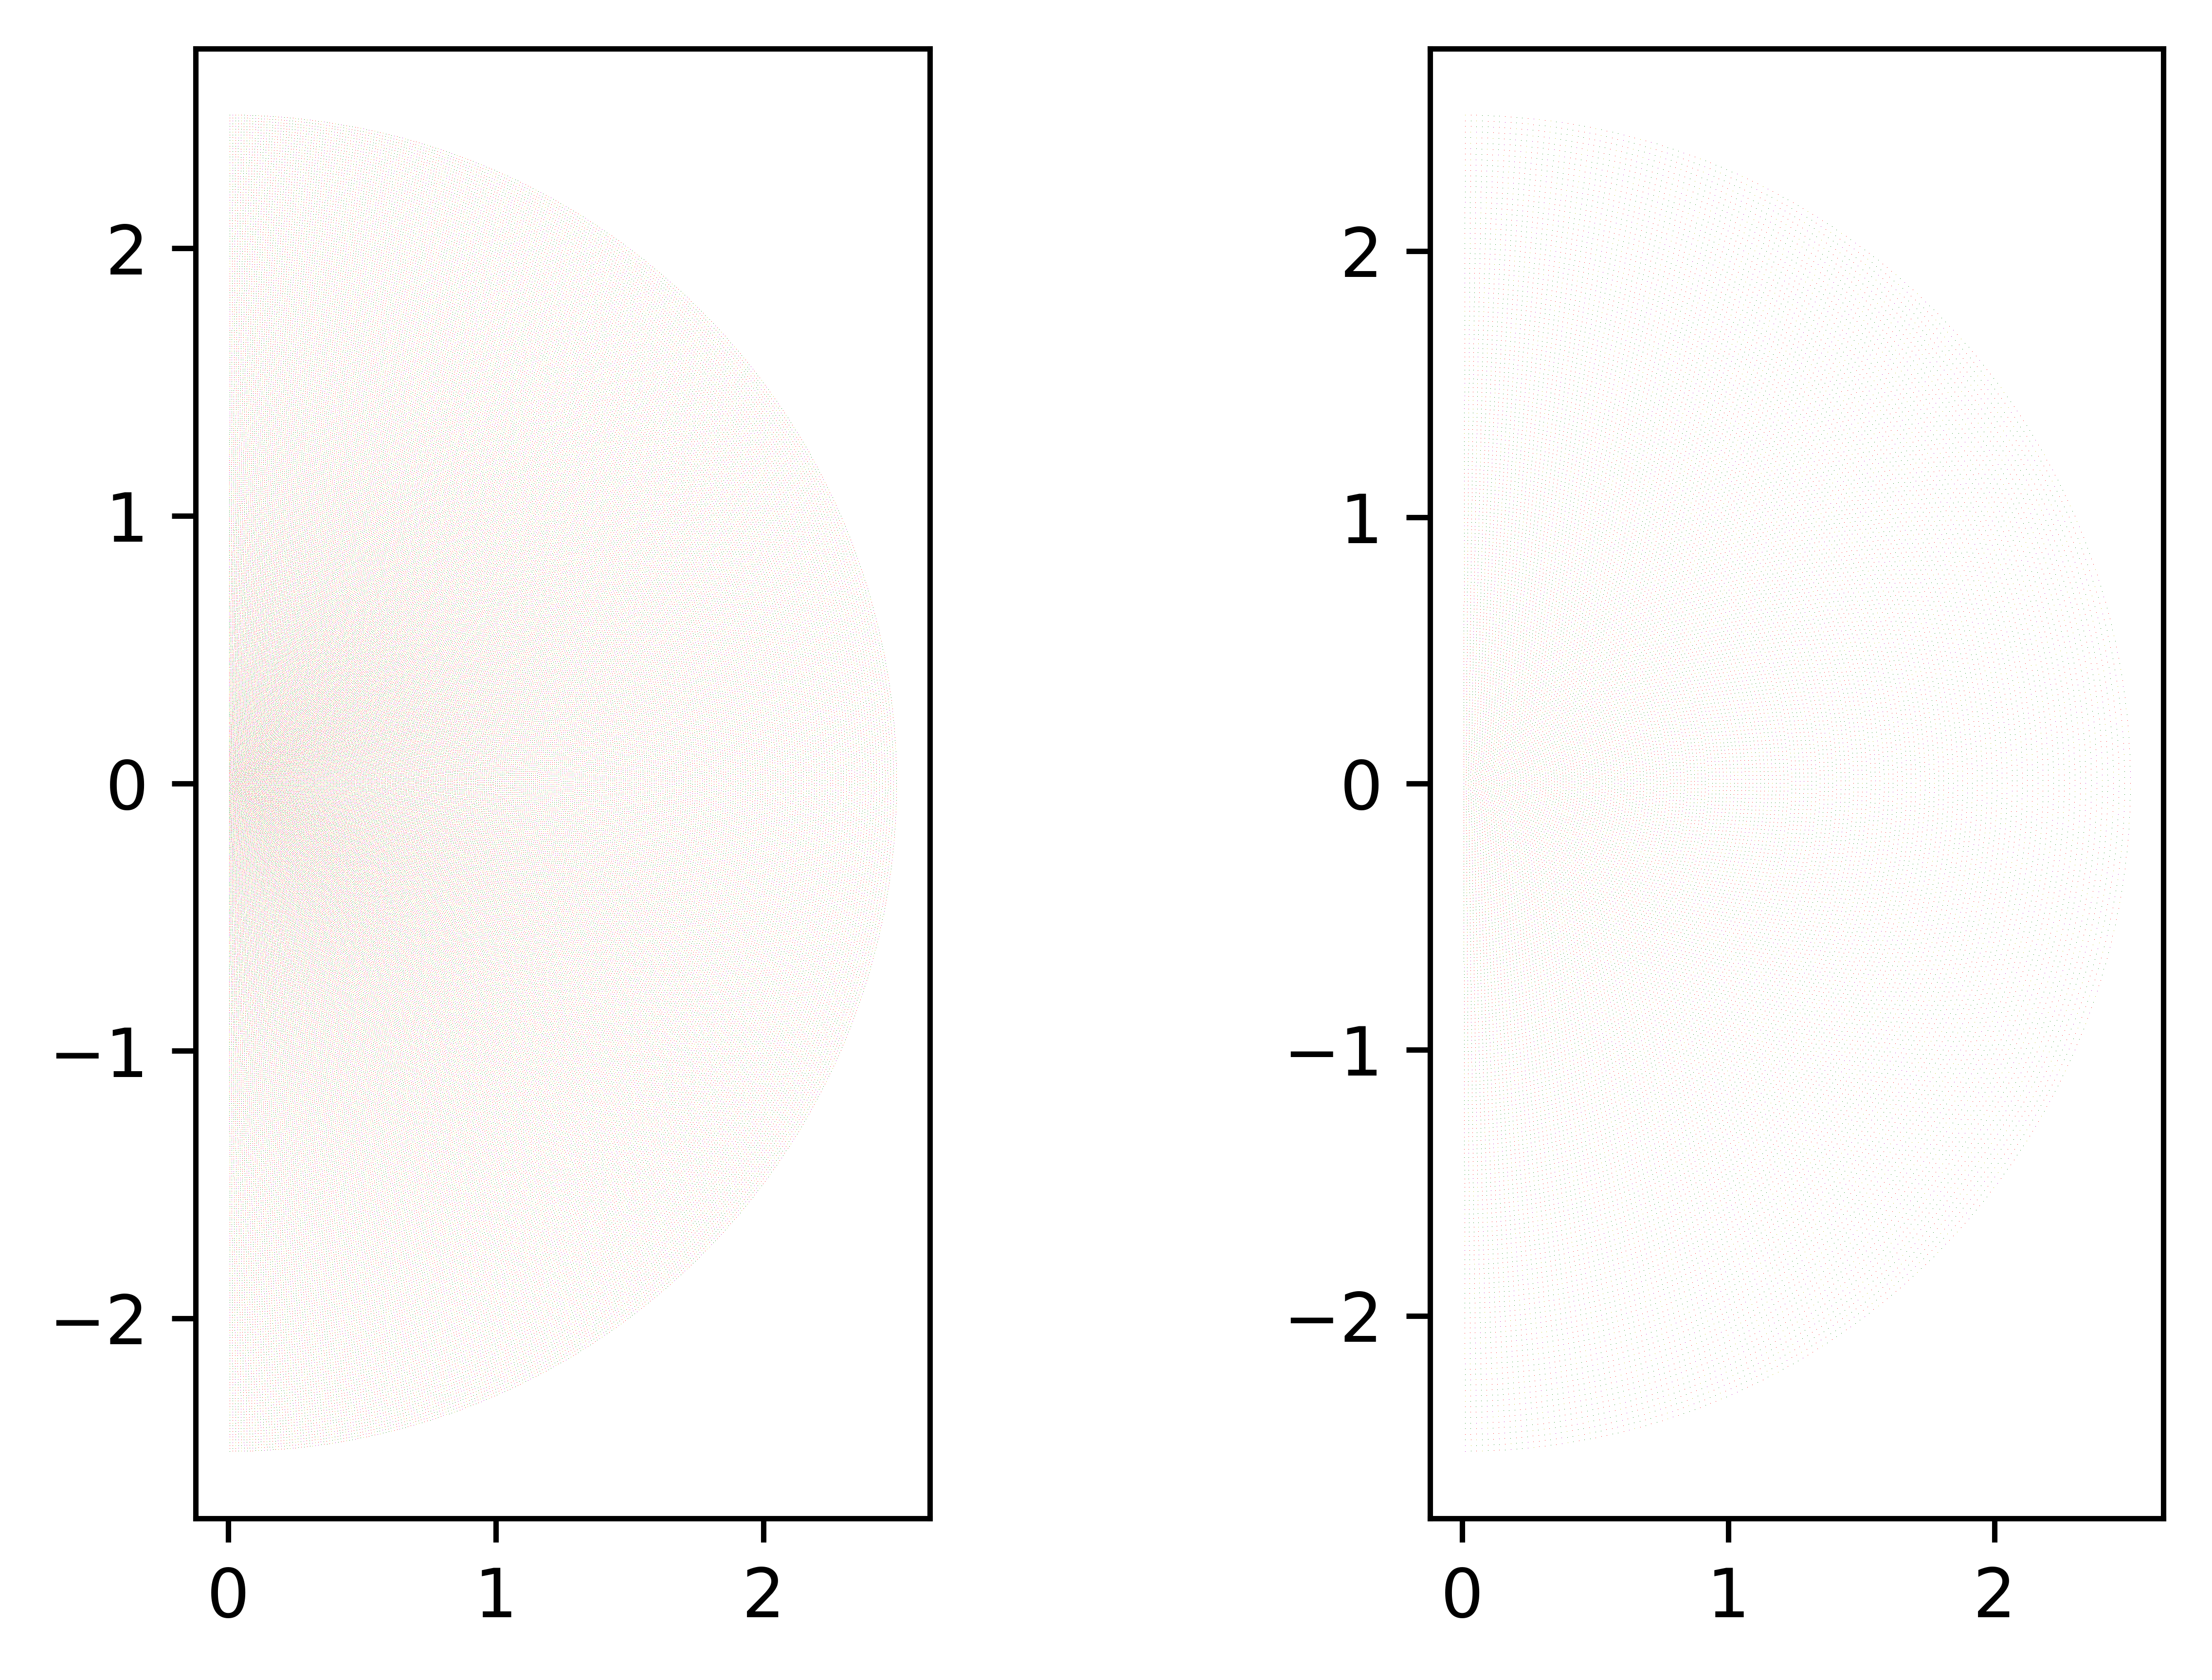

In [12]:
# Excluding S_on, S_off from LGN Koniocellular layers to L1, L2/3 for now
# C-On:Off ~ 3:1; I-On:Off ~ 2:1 (Wiesel and Hubel 1966, Schiller-and-Malpeli-1978, Derrington and Lennie 1984, Martin-and-Lee 2014), cone-to-ganglion ~ 1:1 (McMahon et al., 2000)
# Red:Green, 1.0 central (Bowmaker 2003, cite-only.bib) 1.6 overall(Deeb et al., 2000, cite-only.bib)
rL_on = 0
rL_off = 1
rM_on = 2
rM_off = 3
np.random.seed(74381023)
#                       L                         M
C_sequence = np.array([rL_on,rL_on,rL_off,rL_on, rM_on,rM_on,rM_off,rM_on])
I_sequence = np.array([rL_on,rL_on,rL_off,       rM_on,rM_on,rM_off])
def assign_pos_slice(n, ecc):
    equi_theta = np.linspace(-np.pi/2, np.pi/2, n+1)
    theta = (equi_theta[1:] + equi_theta[:-1])/2
    cartPos = np.zeros((2,n))
    polarPos = np.zeros((2,n))
    polarPos[0,:] = theta
    polarPos[1,:] = ecc
    assert(ecc < 2.511594103743553)
    cartPos[0,:] = np.cos(theta)*ecc
    cartPos[1,:] = np.sin(theta)*ecc
    return polarPos, cartPos

def assign_pos(sliced_N, sliced_ecc, n):
    polarPos = np.zeros((2,n))
    cartPos = np.zeros((2,n))
    nslice = sliced_N.size
    current_n = 0
    for i in range(nslice):
        polarPos[:,current_n:current_n + sliced_N[i]], cartPos[:,current_n:current_n + sliced_N[i]] = assign_pos_slice(sliced_N[i], sliced_ecc[i])
        current_n = current_n + sliced_N[i]
    return polarPos, cartPos

parvo_pos_I5, parvo_pos_I5_cart= assign_pos(Isliced_N, Isliced_ecc, nparvo_I5)
parvo_pos_C6, parvo_pos_C6_cart= assign_pos(Csliced_N, Csliced_ecc, nparvo_C6)

def shuffle_fill(seq, arr):
    seqSize = seq.size
    n = arr.size
    for i in range(n//seqSize+1):
        current_i = i*seqSize
        next_i = current_i + seqSize
        if next_i > n:
            arr[current_i:n] = np.random.permutation(seq)[:n-current_i]
        else:
            arr[current_i:next_i] = np.random.permutation(seq)

RG_OnOff_I5 = np.zeros(nparvo_I5)
shuffle_fill(C_sequence, RG_OnOff_I5)

RG_OnOff_C6 = np.zeros(nparvo_C6)
shuffle_fill(I_sequence, RG_OnOff_C6)
    
fig = plt.figure('LGN_pos', dpi = 1000)
ax = fig.add_subplot(121)
ax.plot(parvo_pos_C6_cart[0,RG_OnOff_C6 == 0], parvo_pos_C6_cart[1,RG_OnOff_C6 == 0], ',r', ms = 0.01)
ax.plot(parvo_pos_C6_cart[0,RG_OnOff_C6 == 1], parvo_pos_C6_cart[1,RG_OnOff_C6 == 1], ',m', ms = 0.01)
ax.plot(parvo_pos_C6_cart[0,RG_OnOff_C6 == 2], parvo_pos_C6_cart[1,RG_OnOff_C6 == 2], ',g', ms = 0.01)
ax.plot(parvo_pos_C6_cart[0,RG_OnOff_C6 == 3], parvo_pos_C6_cart[1,RG_OnOff_C6 == 3], ',y', ms = 0.01)
ax.set_aspect('equal')
ax2 = fig.add_subplot(122)
ax2.plot(parvo_pos_I5_cart[0,RG_OnOff_I5 == 0], parvo_pos_I5_cart[1,RG_OnOff_I5 == 0], ',r')
ax2.plot(parvo_pos_I5_cart[0,RG_OnOff_I5 == 1], parvo_pos_I5_cart[1,RG_OnOff_I5 == 1], ',m')
ax2.plot(parvo_pos_I5_cart[0,RG_OnOff_I5 == 2], parvo_pos_I5_cart[1,RG_OnOff_I5 == 2], ',g')
ax2.plot(parvo_pos_I5_cart[0,RG_OnOff_I5 == 3], parvo_pos_I5_cart[1,RG_OnOff_I5 == 3], ',y')
ax2.set_aspect('equal')
fig.savefig('parvoLGNpos.png')

prec = 'float32'

#for assign_attr.py
parvo_pos_I5_file = 'parvo_pos_I5_cart.bin'
with open(parvo_pos_I5_file, 'wb') as f:
    np.array([nparvo_I5], dtype = 'u4').tofile(f)
    parvo_pos_I5_cart.tofile(f)
    print(parvo_pos_I5_cart.shape)

#for assign_attr.py
parvo_pos_C6_file = 'parvo_pos_C6_cart.bin'
with open(parvo_pos_C6_file, 'wb') as f:
    np.array([nparvo_C6], dtype = 'u4').tofile(f)
    parvo_pos_C6_cart.tofile(f)

parvo_pos_I5_file = 'parvo_pos_I5.bin'
with open(parvo_pos_I5_file, 'wb') as f:
    np.array([nparvo_I5], dtype = 'u4').tofile(f)
    RG_OnOff_I5.astype('int32').tofile(f)
    parvo_pos_I5.astype(prec).tofile(f)
    
parvo_pos_C6_file = 'parvo_pos_C6.bin'
with open(parvo_pos_C6_file, 'wb') as f:
    np.array([nparvo_C6], dtype = 'u4').tofile(f)
    RG_OnOff_C6.astype('int32').tofile(f)
    parvo_pos_C6.astype(prec).tofile(f)
    
LR_merged_file = 'parvo_merged_float.bin'
with open(LR_merged_file, 'wb') as f:
    # Ipsi first
    np.array([nparvo_I5], dtype = 'u4').tofile(f)
    np.array([nparvo_C6], dtype = 'u4').tofile(f)
    np.array([ecc0], dtype = prec).tofile(f)
    np.hstack((RG_OnOff_I5, RG_OnOff_C6)).astype('int32').tofile(f)
    merged = np.hstack((parvo_pos_I5, parvo_pos_C6))
    assert(merged.shape[0] == 2)
    assert(merged.shape[1] == nparvo_I5 + nparvo_C6)
    merged.astype(prec).tofile(f)
print(f'#ipsi = {nparvo_I5}, #contra = {nparvo_C6}')
print(f"{min(parvo_pos_I5[1,:])}, {min(parvo_pos_C6[1,:])}")
print(f"{max(parvo_pos_I5[1,:])}, {max(parvo_pos_C6[1,:])}")

In [8]:
def assign_pos_slice_uniform(n, ecc):
    equi_theta = np.linspace(-np.pi/2, np.pi/2, n+1)
    theta = (equi_theta[1:] + equi_theta[:-1])/2
    cartPos = np.zeros((2,n))
    polarPos = np.zeros((2,n))
    polarPos[0,:] = theta
    polarPos[1,:] = ecc
    assert(ecc < 2.511594103743553)
    cartPos[0,:] = np.cos(theta)*ecc
    cartPos[1,:] = np.sin(theta)*ecc
    return polarPos, cartPos

def assign_pos_uniform(sliced_N, sliced_ecc, n):
    polarPos = np.zeros((2,n))
    cartPos = np.zeros((2,n))
    nslice = sliced_N.size
    current_n = 0
    for i in range(nslice):
        polarPos[:,current_n:current_n + sliced_N[i]], cartPos[:,current_n:current_n + sliced_N[i]] = assign_pos_slice_uniform(sliced_N[i], sliced_ecc[i])
        current_n = current_n + sliced_N[i]
    return polarPos, cartPos

parvo_pos_I5, parvo_pos_I5_cart= assign_pos_uniform(Isliced_N, Isliced_ecc, nparvo_I5)
parvo_pos_C6, parvo_pos_C6_cart= assign_pos_uniform(Csliced_N, Csliced_ecc, nparvo_C6)

In [8]:
def area(raxn, rden, d):
    area = np.zeros(d.size)
    minr = max(raxn,rden) - min(raxn,rden)
    maxr = max(raxn,rden) + min(raxn,rden)
    area[d <= minr] = np.power(min(raxn,rden),2)*np.pi
    mid_pick = np.logical_and(minr < d, d < maxr)
    d_mid = d[mid_pick]
    cos_theta_axn = (raxn*raxn + d_mid*d_mid - rden*rden)/(2*raxn*d_mid)
    cos_theta_den = (rden*rden + d_mid*d_mid - raxn*raxn)/(2*rden*d_mid)
    seg_axn = np.arccos(cos_theta_axn)*raxn*raxn
    seg_den = np.arccos(cos_theta_den)*rden*rden

    chord_axn = np.sqrt(raxn*raxn - np.power(cos_theta_axn*raxn,2)) * raxn * cos_theta_axn
    chord_den = np.sqrt(rden*rden - np.power(cos_theta_den*rden,2)) * rden * cos_theta_den
    area[mid_pick] = seg_axn+seg_den-chord_axn-chord_den
    assert(np.sum(area<0) == 0)
    return area

def base(raxn, rden, d):
    #subr = d-raxn
    #subr[subr<0] = 0
    #supr = d+raxn
    #supr[supr>rden] = rden
    #base = np.pi*(np.power(supr,2) - np.power(subr,2))
    base = np.pi*(np.power(raxn,2))
    return base

(12.5, 150.0)

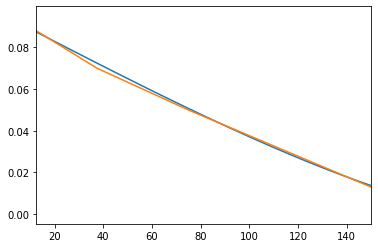

In [9]:
raxn = 100 #um
rden = 100
nd = 100
dd = (raxn+rden)/nd
dee = np.linspace(0,raxn+rden-dd,nd-1)

fig = plt.figure('prob')
ax = fig.add_subplot(111)
ratio = 0.095
ax.plot(dee,  area(raxn,rden,dee)/base(raxn,rden,dee)*ratio)
x = np.array([12.5, 37.5, 75, 150])
y = np.array([8.8, 7.0, 5.0, 1.3])/100
ax.plot(x,y)
ax.set_xlim(x[0],x[-1])

(12.5, 75)

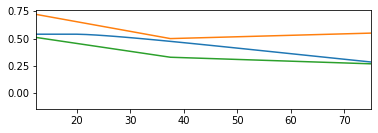

In [10]:
raxn = 100
rden = 80
nd = 100
dd = (raxn+rden)/nd
dii = np.linspace(0, raxn+rden-dd,nd-1)
fig = plt.figure('prob')
ax = fig.add_subplot(211)
y = area(raxn,rden,dii)/base(raxn,rden,dii)
baseline = -0.1
ratio = 1
ax.plot(dii,y*ratio+baseline)
x = [12.5, 37.5, 75]
y = [0.72, 0.50, 0.55]
yr = [0.51, 0.33, 0.27]
ax.plot(x,y)
ax.plot(x,yr)
ax.set_xlim(x[0],x[-1])

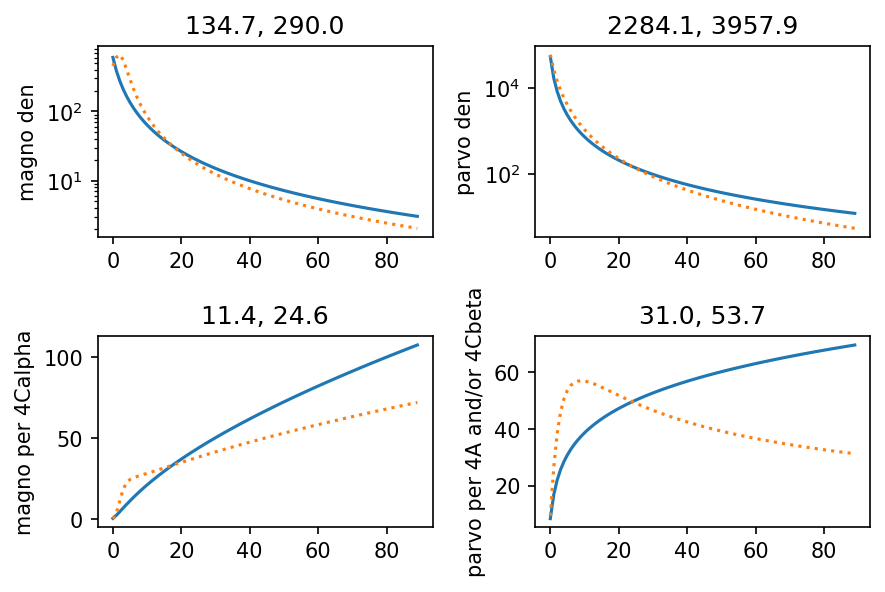

In [49]:
#Connelly-Van_Essen-1984 
Ap = 8.37
Bp = 1.28
Cp = -1.96
parvo_den = lambda E: Ap*(E+Bp)**Cp*10000 # cells/deg^2
Am = 3.52
Bm = 3.1
Cm = -1.56
magno_den = lambda E: Am*(E+Bm)**Cm*1000# cells/deg^2
deg = 5
#consistent Maplpeli et al 1996
parvo_den_alt = lambda E: 1011688*(E+2.9144)**(-2.6798)
magno_den_alt = lambda E: 2620.2*((E-1.8322)**2+5.5638)**(-0.8012)
fig = plt.figure('lgn cell areal mf', dpi=150)
ax = fig.add_subplot(221)
ecc = np.arange(0,90)
ax.plot(ecc, magno_den(ecc))
ax.plot(ecc, magno_den_alt(ecc),':')
ax.set_title(f'{magno_den(deg):.1f}, {magno_den_alt(deg):.1f}')
ax.set_ylabel('magno den')
ax.set_yscale('log')
ax = fig.add_subplot(222)
ax.plot(ecc, parvo_den(ecc))
ax.plot(ecc, parvo_den_alt(ecc),':')
ax.set_yscale('log')
ax.set_title(f'{parvo_den(deg):.1f}, {parvo_den_alt(deg):.1f}')
ax.set_ylabel('parvo den') 
est_4Cbeta_over_4A = 0.6
#blasdel and lund 1983,
magno_spread = 0.5 # mm (mean) 
parvo_spread = 0.1 # mm (upper limit)
surface_den_L4Calpha = 17300
magno_spread_reach_max = surface_den_L4Calpha*magno_spread**2
parvo_spread_reach_max = surface_den_L4Cbeta*parvo_spread**2
ax = fig.add_subplot(223)
ax.plot(ecc, magno_den(ecc)/darea(ecc,0)*magno_spread**2)
ax.plot(ecc, magno_den_alt(ecc)/darea(ecc,0)*magno_spread**2, ':')
ax.set_ylabel('magno per 4Calpha')
ax.set_title(f'{magno_den(deg)/darea(deg,0)*magno_spread**2:.1f}, {magno_den_alt(deg)/darea(deg,0)*magno_spread**2:.1f}')
ax = fig.add_subplot(224)
ax.plot(ecc, parvo_den(ecc)/darea(ecc,0)*parvo_spread**2)
ax.plot(ecc, parvo_den_alt(ecc)/darea(ecc,0)*parvo_spread**2, ':')
ax.set_ylabel('parvo per 4A and/or 4Cbeta')
ax.set_title(f'{parvo_den(deg)/darea(deg,0)*parvo_spread**2:.1f}, {parvo_den_alt(deg)/darea(deg,0)*parvo_spread**2:.1f}')
plt.tight_layout()

In [50]:
fig.savefig('upper_limit_of_nLGN_per_V1.png')

In [51]:
deg = 5
p_den = lambda E: 110000*(E+1.28)**(-1.96) #cell/deg^2
m_den = lambda E: 4600*(E+3.12)**(-1.56) #cell/deg^2
print(p_den(deg),m_den(deg))
areal_cmf = lambda E: 12.2**2*(E+0.94)**(-2.0) # mm^2/deg^2
print(areal_cmf(deg))
parvo_per_p = p_den(deg)/areal_cmf(deg)
print(f'{parvo_per_p:.1f} P cells/mm^2 to 4Cbeta + 4A')
magno_per_m = m_den(deg)/areal_cmf(deg)
print(f'{magno_per_m:.1f} M cells/mm^2 to 4Calpha')

3001.8693283061225 175.32765576316365
4.218390413676609
711.6 P cells/mm^2 to 4Cbeta + 4A
41.6 M cells/mm^2 to 4Calpha


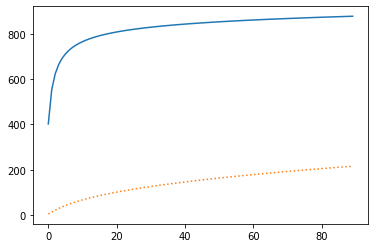

In [52]:
fig = plt.figure('Schein')
ax = fig.add_subplot(111)
ax.plot(ecc, p_den(ecc)/areal_cmf(ecc))
ax.plot(ecc, m_den(ecc)/areal_cmf(ecc),':')